<a href="https://colab.research.google.com/github/DaiVo20/za_traffic_detection/blob/main/keras_retinanet/image_tiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import cv2
import os
import ast
import random
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
from matplotlib.pyplot import figure
from shapely.geometry import Polygon
import seaborn as sns
from tqdm import tqdm

In [3]:
def get_image(img_name):
    return np.array(Image.open(img_name))

def plot_image_and_bboxes(img, bboxes):
    fig, ax = plt.subplots(1, figsize=(20, 16))
    ax.axis('off')
    ax.imshow(img)
    
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor="none")
        ax.add_patch(rect)
    
    plt.show()

def image_tiler(img, s_h, s_w):
    tiles = [img[x : x + s_h, y : y + s_w] for x in range(0, img.shape[0], s_h) for y in range(0, img.shape[1], s_w)]
    return tiles

def tiler(img_name, bboxes, s_h, s_w, height = 626, width = 1622):
    basename   = os.path.basename(os.path.splitext(img_name)[0])

    tiles_dict = {}
    boxes      = []
    
    for bbox in bboxes:
        x1 = bbox[0]
        y1 = bbox[1]
        x2 = bbox[0] + bbox[2]
        y2 = bbox[1] + bbox[3]
        boxes.append(Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]))
    for i in range((height // s_h)):
        for j in range((width // s_w)):
            
            x1 = j*s_w
            y1 = height - (i*s_h)
            x2 = ((j+1)*s_w)
            y2 = (height - (i+1)*s_h)
            pol = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
            
            slice_labels = []
            
            for box, bbox_label in zip(boxes, bboxes):
                if pol.intersects(box):
                    inter = pol.intersection(box)                        
                    # get the smallest polygon (with sides parallel to the coordinate axes) that contains the intersection
                    new_box = inter.envelope
                    
                    # get coordinates of polygon vertices
                    x, y = new_box.exterior.coords.xy
                    
                    new_width  = (max(x) - min(x))
                    new_height = (max(y) - min(y))
                    
                    # Get new_x min and new_y min
                    new_x = (min(x) - x1)
                    new_y = (min(y) - y2)
                    
                    # Remove small bbox (unsignificant for training)
                    # Chỉ lấy các bounding box chiếm diện tích từ 0.5 trở lên
                    if ((new_width > 14) and (new_height > 14)) and ((new_width * new_height) / box.area >= 0.5):
                        slice_labels.append([new_x, new_y, new_width, new_height, bbox_label[4]])

                    # if ((new_width > 14) and (new_height > 14)):
                    #     slice_labels.append([new_x, new_y, new_width, new_height])
                    
            tiles_dict[basename + "-" + str(IMAGE_SPLIT-i-1)+"-"+str(j)] = slice_labels
    return dict(sorted(tiles_dict.items()))

def keep_bboxes_tiles(tiles, tiles_dict):
    bboxes_tiles = {}
    tiles_keys = [*tiles_dict]
    for k, v in tiles_dict.items():
        if len(v):
            tile_index = tiles_keys.index(k)
            bboxes_tiles[k] = np.array([tiles[tile_index], np.array(v)], dtype=object)
    return bboxes_tiles


def tiler_plot(img_name, bboxes, s_h, s_w, height = 626, width = 1622):
    basename = os.path.basename(os.path.splitext(img_name)[0])

    tiles_dict = {}
    boxes = []
    
    fig, ax = plt.subplots(1, figsize=(10, 4))
    ax.axis('off')
    plt.gca().invert_yaxis()
    
    
    for bbox in bboxes:
        x1 = bbox[0]
        y1 = bbox[1]
        x2 = bbox[0] + bbox[2]
        y2 = bbox[1] + bbox[3]
        boxes.append(Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]))
      
    for i in range((height // s_h)):
        for j in range((width // s_w)):
            
            x1 = j*s_w
            y1 = height - (i*s_h)
            x2 = ((j+1)*s_w)
            y2 = (height - (i+1)*s_h)
            pol = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
            
            slice_labels = []
            ax.plot(*pol.exterior.xy)

            for box in boxes:
                if pol.intersects(box):
                    inter = pol.intersection(box)                        
                    new_box = inter.envelope 
                    ax.plot(*new_box.exterior.coords.xy)

In [11]:
def split_image_and_save(image_split, df_data, path_save_image, path_save_csv, width=1620, height=624):
    slice_height = height//image_split
    slice_width = width//image_split

    results = {
        'file_name': [],
        'xmin': [],
        'ymin': [],
        'xmax': [],
        'ymax': [],
        'width': [],
        'height': [],
        'label': [],
    }

    total = len(df_data['file_name'].unique())
    errors = []

    for index, file_name in tqdm(enumerate(df_data['file_name'].unique())):
        df = df_data[df_data['file_name'] == file_name]

        img = get_image(file_name)
        img = img[0:height, 0:width]

        bboxes = []
        for c in df.index:
            bboxes.append((df.loc[c, 'xmin'],
                           df.loc[c, 'ymin'],
                           df.loc[c, 'xmax'] - df.loc[c, 'xmin'],
                           df.loc[c, 'ymax'] - df.loc[c, 'ymin'],
                           df.loc[c, 'label']))

        try:
            tiles_dict = tiler(file_name, bboxes, slice_height, slice_width)
            tiles = image_tiler(img, slice_height, slice_width)
        except:
            errors.append(file_name)
            continue

        to_save = keep_bboxes_tiles(tiles, tiles_dict)

        for key, value in to_save.items():
            part_image = value[0]
            bbox_parts = value[1].astype(int)

            # plot_image_and_bboxes(part_image, bbox_parts)

            path_save = os.path.join(path_save_image, key.replace('-', '_') + ".png")
            cv2.imwrite(path_save, cv2.cvtColor(part_image, cv2.COLOR_BGRA2RGB))

            for bbox_part in bbox_parts:
                results['file_name'].append(path_save)
                results['xmin'].append(bbox_part[0])
                results['ymin'].append(bbox_part[1])
                results['xmax'].append(bbox_part[0] + bbox_part[2])
                results['ymax'].append(bbox_part[1] + bbox_part[3])
                results['width'].append(bbox_part[2])
                results['height'].append(bbox_part[3])
                results['label'].append(bbox_part[4])

    df_result = pd.DataFrame(results)
    df_result.to_csv(path_save_csv, index=None)
    num_image_bbox = len(df_result['file_name'].unique())

    return df_result, num_image_bbox

def crop_image_keep_all(image_split, df_data, path_save_image, path_save_csv, width=1620, height=624):
    slice_height = height//image_split
    slice_width = width//image_split

    results = {
        'file_name': [],
        'xmin': [],
        'ymin': [],
        'xmax': [],
        'ymax': [],
        'width': [],
        'height': [],
        'label': [],
    }

    total = len(df_data['file_name'].unique())
    errors = []

    for index, file_name in tqdm(enumerate(df_data['file_name'].unique())):
        df = df_data[df_data['file_name'] == file_name]

        img = get_image(file_name)
        img = img[0:height, 0:width]

        bboxes = []
        for c in df.index:
            bboxes.append((df.loc[c, 'xmin'],
                           df.loc[c, 'ymin'],
                           df.loc[c, 'xmax'] - df.loc[c, 'xmin'],
                           df.loc[c, 'ymax'] - df.loc[c, 'ymin'],
                           df.loc[c, 'label']))

        try:
            tiles_dict = tiler(file_name, bboxes, slice_height, slice_width)
            tiles = image_tiler(img, slice_height, slice_width)
        except:
            errors.append(file_name)
            continue

        bboxes_tiles = {}
        tiles_keys = [*tiles_dict]
        for k, v in tiles_dict.items():
            tile_index = tiles_keys.index(k)
            bboxes_tiles[k] = np.array([tiles[tile_index], np.array(v)], dtype=object)

        for key, value in bboxes_tiles.items():
            part_image = value[0]
            bbox_parts = value[1].astype(int)

            # plot_image_and_bboxes(part_image, bbox_parts)

            path_save = os.path.join(path_save_image, key.replace('-', '_') + ".png")
            cv2.imwrite(path_save, cv2.cvtColor(part_image, cv2.COLOR_BGRA2RGB))

            for bbox_part in bbox_parts:
                results['file_name'].append(path_save)
                results['xmin'].append(bbox_part[0])
                results['ymin'].append(bbox_part[1])
                results['xmax'].append(bbox_part[0] + bbox_part[2])
                results['ymax'].append(bbox_part[1] + bbox_part[3])
                results['width'].append(bbox_part[2])
                results['height'].append(bbox_part[3])
                results['label'].append(bbox_part[4])

    df_result = pd.DataFrame(results)
    df_result.to_csv(path_save_csv, index=None)
    num_image_bbox = len(df_result['file_name'].unique())

    return df_result, num_image_bbox

In [7]:
WIDTH         = 1620
HEIGHT        = 624

In [6]:
PATH_DATA = "/content/drive/MyDrive/TrafficSign/data/za_traffic_2020"
df_train =  pd.read_csv(os.path.join(PATH_DATA, "traffic_train", "train_filter.csv"))
df_test =  pd.read_csv(os.path.join(PATH_DATA, "traffic_public_test", "test.csv"))

In [8]:
df_train['xmax'] = df_train['xmax'].replace(1621, WIDTH)
df_train['ymax'] = df_train['ymax'].replace(625, HEIGHT)

for i in range(1621, 1626):
    df_test['xmax'] = df_test['xmax'].replace(i, WIDTH)

# **Sample**

In [9]:
df_train['file_name'][8]

'drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_train/images/18.png'

In [ ]:
IMAGE_SPLIT   = 4

file_name = 'drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_train/images/3.png'
df_sample = df_train[df_train['file_name'] == file_name]

img = get_image(file_name)
bboxes = []
for c in df_sample.index:
    bboxes.append((df_sample.loc[c,'xmin'],
                   df_sample.loc[c,'ymin'],
                   df_sample.loc[c,'xmax'] - df_sample.loc[c,'xmin'],
                   df_sample.loc[c,'ymax'] - df_sample.loc[c,'ymin'],
                   df_sample.loc[c,'label']))

img = img[0:HEIGHT, 0:WIDTH]

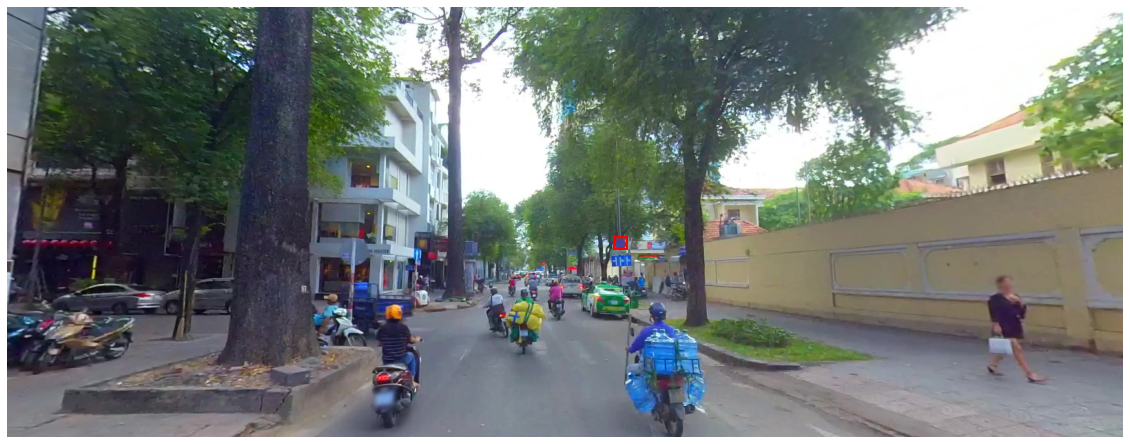

In [ ]:
plot_image_and_bboxes(img, bboxes)

slice_height=156
slice_width=405


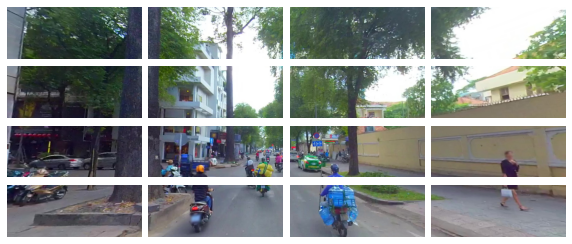

In [ ]:
slice_height = HEIGHT//IMAGE_SPLIT
slice_width = WIDTH//IMAGE_SPLIT
print(f"slice_height={slice_height}")
print(f"slice_width={slice_width}")
tiles_dict = tiler(file_name, bboxes, slice_height, slice_width)
tiles  = image_tiler(img, slice_height, slice_width)

_, axs = plt.subplots(IMAGE_SPLIT, IMAGE_SPLIT, figsize=(10, 6))
axs = axs.flatten()
for img, ax in zip(tiles, axs):
    ax.axis('off')
    ax.imshow(img)
plt.subplots_adjust(wspace=0.05, hspace=-0.6)
plt.show()

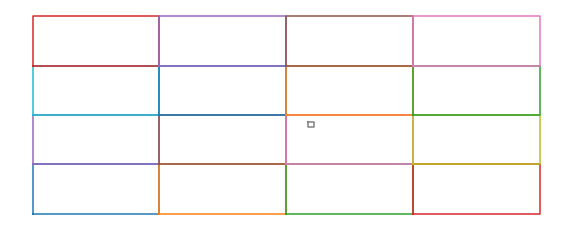

In [ ]:
tiler_plot(file_name, bboxes, slice_height, slice_width, height = 624, width = 1620)

IMAGE NAME : 10068-0-0
NEW BBOXES : [[508. 158.   6.   7.   5.]
 [507. 158.   7.   7.   5.]]


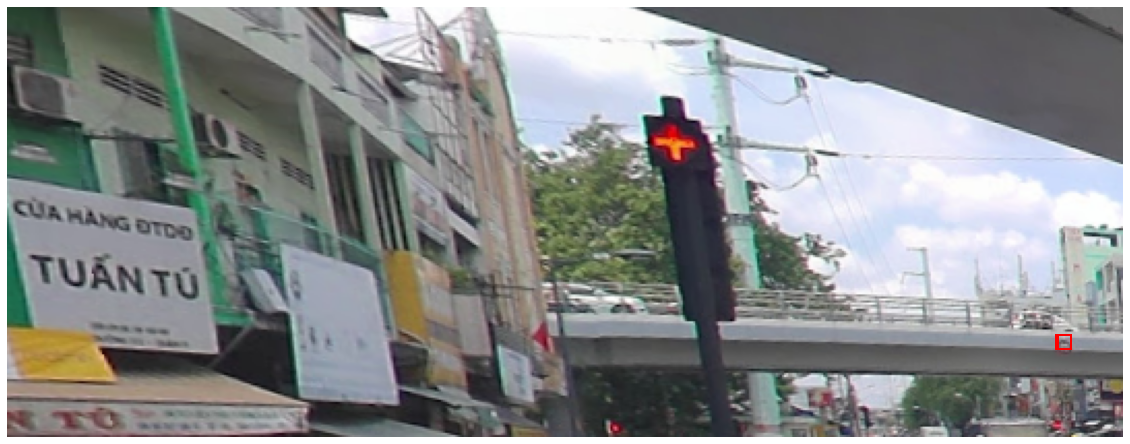

IMAGE NAME : 10068-0-1
NEW BBOXES : [[488. 191.   9.   9.   3.]
 [198.   7.  16.  30.   5.]
 [367. 137.   6.   6.   3.]
 [481. 197.   5.   5.   5.]
 [489. 191.   9.   8.   3.]
 [481. 197.   4.   5.   5.]
 [366. 137.   6.   6.   3.]
 [198.   8.  16.  30.   5.]]


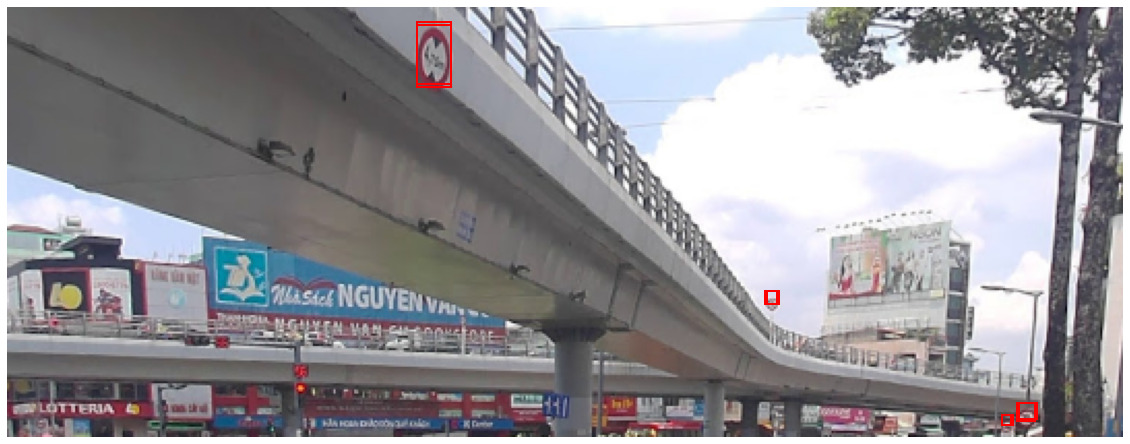

In [ ]:
to_save = keep_bboxes_tiles(tiles, tiles_dict)
for k, v in to_save.items():
    print("IMAGE NAME :", k)
    print("NEW BBOXES :", v[1])
    plot_image_and_bboxes(v[0], v[1])

# **Crop test set**

In [5]:
WIDTH         = 1620
HEIGHT        = 624

In [ ]:
PATH_SAVE = "/content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/image_crop/traffic_public_test"
IMAGE_SPLIT = 4
df_croped, num_image_bbox = split_image_and_save(image_split=IMAGE_SPLIT,
                                                 df_data=df_test,
                                                 path_save_image=os.path.join(PATH_SAVE, "images"),
                                                 path_save_csv=os.path.join(PATH_SAVE, "test_croped.csv"),
                                                 width=WIDTH,
                                                 height=HEIGHT)

In [14]:
PATH_SAVE = "/content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/image_crop/traffic_public_test_all"
IMAGE_SPLIT = 4
df_croped, num_image_bbox = crop_image_keep_all(image_split=IMAGE_SPLIT,
                                                df_data=df_test,
                                                path_save_image=os.path.join(PATH_SAVE, "images"),
                                                path_save_csv=os.path.join(PATH_SAVE, "test_all_croped.csv"),
                                                width=WIDTH,
                                                height=HEIGHT)

0it [00:00, ?it/s]

# **Crop train set**

In [ ]:
PATH_SAVE = "/content/drive/MyDrive/TrafficSign/Model/RetinaNet/data_crop/image_crop/traffic_train"
IMAGE_SPLIT = 4
df_croped, num_image_bbox = split_image_and_save(image_split=IMAGE_SPLIT,
                                                 df_data=df_train,
                                                 path_save_image=os.path.join(PATH_SAVE, "images"),
                                                 path_save_csv=os.path.join(PATH_SAVE, "train_croped.csv"),
                                                 width=WIDTH,
                                                 height=HEIGHT)